# Импортируем необходимые библиотеки

In [2522]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from collections import Counter
from imblearn.over_sampling import SMOTE 
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
RANDOM_SEED = 42

# Откройте файл с данными

In [2523]:
columns = ["calls",  "minutes",  "message","md_used", "is_ultra"]
df_tarific = pd.read_csv("users_behavior.csv",
                 names=columns,
                 header=1) 

In [2524]:
df_tarific.head()

,calls,minutes,message,md_used,is_ultra
0,85.0,516.75,56.0,22696.96,0
1,77.0,467.66,86.0,21060.45,0
2,106.0,745.53,81.0,8437.39,1
3,66.0,418.74,1.0,14502.75,0
4,58.0,344.56,21.0,15823.37,0


In [2525]:
df_tarific.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3213 entries, 0 to 3212
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3213 non-null   float64
 1   minutes   3213 non-null   float64
 2   message   3213 non-null   float64
 3   md_used   3213 non-null   float64
 4   is_ultra  3213 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.6 KB


In [2526]:
df_tarific.describe()

,calls,minutes,message,md_used,is_ultra
count,3213.000000,3213.000000,3213.000000,3213.000000,3213.000000
mean,63.046063,438.248098,38.267351,17206.831089,0.306567
std,33.239054,234.595795,36.145338,7571.995923,0.461140
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.530000,9.000000,12491.750000,0.000000
50%,62.000000,430.700000,30.000000,16942.030000,0.000000
75%,82.000000,572.030000,57.000000,21425.840000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


Вывод: 
1. Пропущенных значений нет
1. Типы столбцов в порядке
1. Дубликатов нет

Исследовательский анализ данных

<Axes: >

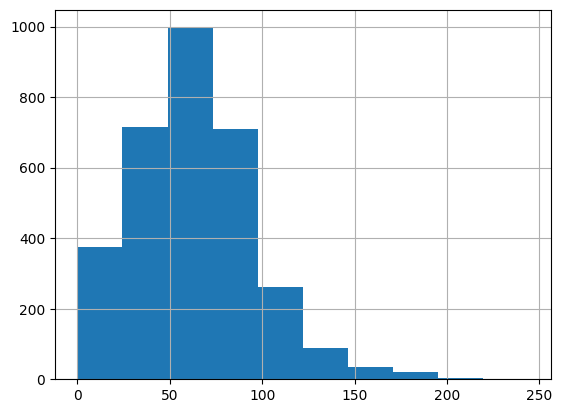

In [2527]:
df_tarific['calls'].hist()

Данные в разрезе тарифов

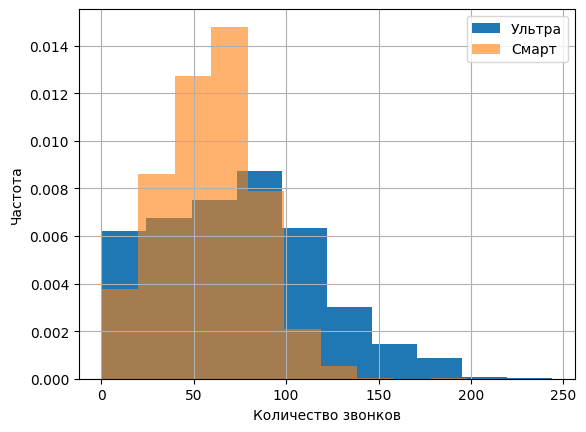

In [2528]:
df_tarific.query('is_ultra == 1')['calls'].hist(density=True)
df_tarific.query('is_ultra == 0')['calls'].hist(density=True, alpha=0.6)

plt.xlabel("Количество звонков")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Исходя из полученных гистограмм, можно сделать вывод, что тариф "Ультра" является менее популярным чем тариф "Смарт". Однако пользователи тарифа "Ультра" проявляют наибольшую активность совершаемых звонков в сравнении с тарифом "Смарт".     </font>
    </b>
</div>

<div class="alert alert-warning">
<b>а мне казалось что доля is_ultra 0.3 - это говорит о том, что ультра наоборот, не очень популярный. проверь формулировку выводов

</b>
</div>

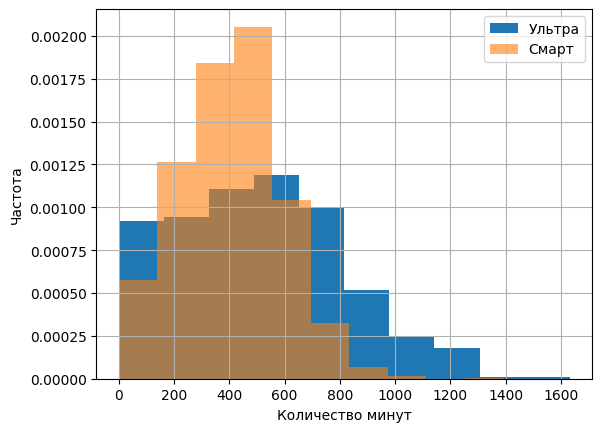

In [2529]:
df_tarific.query('is_ultra == 1')['minutes'].hist(density=True)
df_tarific.query('is_ultra == 0')['minutes'].hist(alpha=0.6, density=True)

plt.xlabel("Количество минут")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple"> Вывод: Схожая ситуация и с количеством потребляемых минут у пользователей тарифов "Смарт" и "Ультра". Пользователи тарифа "Ультра" проявляют высокую активность в использовании минут, несмотря на меньшую популярность самого тарифа. </font>
    </b>
</div>

<div class="alert alert-warning">
<b>корреляция не всесильная штука, между категориальной переменной и количественной переменной вообще нельзя оценивать корреляцию:

https://stats.stackexchange.com/questions/129585/is-there-a-correlation-index-for-binary-variable-vs-quantitative-variables

https://www.codecamp.ru/blog/correlation-between-categorical-variables/
</b>
</div>

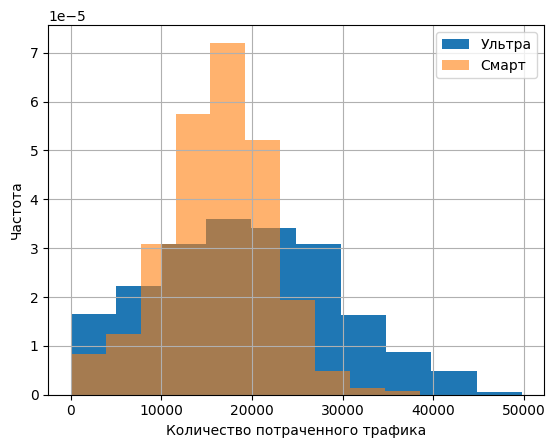

In [2530]:
df_tarific.query('is_ultra == 1')['md_used'].hist(density=True) # Ультра 
df_tarific.query('is_ultra == 0')['md_used'].hist(alpha=0.6, density=True) # Смарт

plt.xlabel("Количество потраченного трафика")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Колличество потраченного интернет трафика говорит нам, что тариф "Ультра", имеет наибольшую интенсивность использования (Пик частоты приходиться на интервал от 10 до 30 гБ). Тариф "Смарт" по прежнему имеет большое колличиство пользователей, и пик частоты использования интернета приходиться на интервал от 10 до 20 гБ. </font>
    </b>
</div>

<div class="alert alert-warning">
<b>а ультра при этом как себя ведут?
</b>
</div>

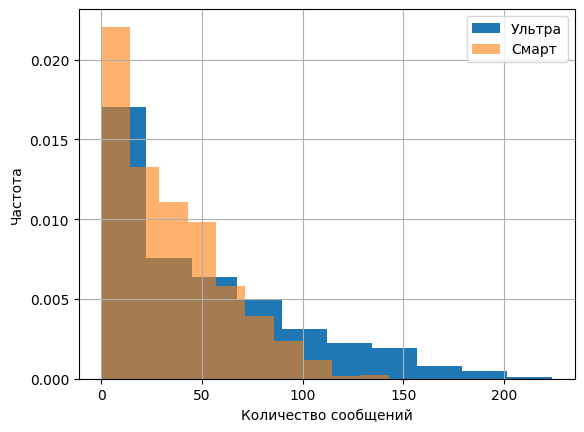

In [2531]:
df_tarific.query('is_ultra == 1')['message'].hist(density=True) # Ультра 
df_tarific.query('is_ultra == 0')['message'].hist(alpha=0.6, density=True) # Смарт 

plt.xlabel("Количество сообщений")
plt.ylabel("Частота")
plt.legend(labels=["Ультра", "Смарт"])
plt.show()

<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: Исходя из данной гистограммы можно сделать вывод, что у пользователи тарифов "Смарт" и "Ультра" количество отправки собщений менее интенсивно в сравнении с другими предоставляемыми услугами. Пик частоты использование услуги приходятся на тариф "Смарт" от 0 до 50 сообщений, но у тарифа "Ультра" пик частоты приходиться от 0 - 100.     </font>
    </b>
</div>


<div class="alert alert-warning">
<b>статистический критерий без текстового пояснения бесполезен - что ты тут считаешь? вообще хз.  по гистограмме можно сказать что пользователи ультра звонят больше
</b>
</div>

<div class="alert alert-warning">
<b>здорово, что данные визуализировал - не хватает только выводов по графикам. хотя бы пару слов.</b>
</div>

In [2532]:
df_tarific.query('is_ultra == 1').describe() # Ультра 

,calls,minutes,message,md_used,is_ultra
count,985.000000,985.000000,985.000000,985.000000,985.0
mean,73.392893,511.224569,49.363452,19468.823228,1.0
std,43.916853,308.031100,47.804457,10087.178654,0.0
min,0.000000,0.000000,0.000000,0.000000,1.0
25%,41.000000,276.030000,6.000000,11770.280000,1.0
50%,74.000000,502.550000,38.000000,19308.010000,1.0
75%,104.000000,730.050000,79.000000,26837.720000,1.0
max,244.000000,1632.060000,224.000000,49745.730000,1.0


In [2533]:
df_tarific.query('is_ultra == 0').describe() # Смарт 

,calls,minutes,message,md_used,is_ultra
count,2228.000000,2228.000000,2228.000000,2228.000000,2228.0
mean,58.471724,405.985162,33.361759,16206.803146,0.0
std,25.942730,184.543262,28.214621,5871.291048,0.0
min,0.000000,0.000000,0.000000,0.000000,0.0
25%,40.000000,274.130000,10.000000,12638.732500,0.0
50%,60.000000,410.605000,28.000000,16505.565000,0.0
75%,76.000000,529.515000,51.000000,20043.907500,0.0
max,198.000000,1390.220000,143.000000,38552.620000,0.0


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
<b>
<font color="purple">

Заключение: Исходя из данных двух таблиц статистики для тарифов "Ультра" и "Смарт" можно сделать следующие выводы:

1. Среднее количество звонков у пользователей тарифа "Ультра" выше - 73 звонка против 58 у "Смарта".

2. Средняя длительность разговоров также больше для "Ультра" - 511 минут против 406 минут у "Смарта". 

3. Среднее количество sms сообщений выше у "Ультра" - 49 против 33 у "Смарта".

4. Использованный интернет-трафик в среднем также интенсивнее используется абонентами "Ультра" - почти 19.5 Гб против 16.2 Гб.

Таким образом, несмотря на меньшую абонентскую базу, пользователи тарифа "Ультра" используют услуги сотовой связи значительно интенсивнее в сравнении с тарифом "Смарт"

</font>
</b>
</div>

<Axes: >

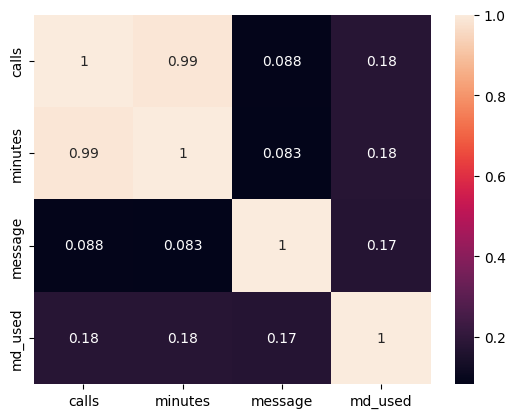

In [2534]:
sns.heatmap(df_tarific.query('is_ultra == 1').drop('is_ultra', axis=1).corr(), annot=True)

<Axes: >

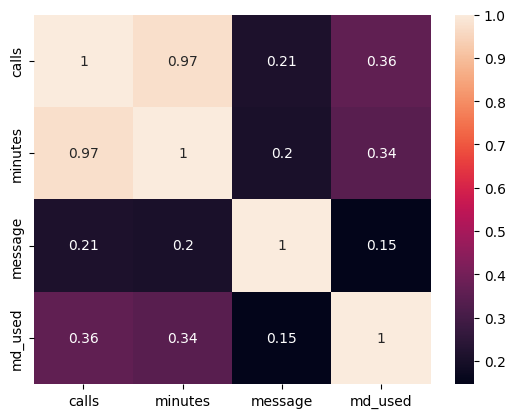

In [2535]:
sns.heatmap(df_tarific.query('is_ultra == 0').drop('is_ultra', axis=1).corr(), annot=True)

<div class="alert alert-warning">
<b>выводы?</b>
</div>


<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">
Вывод: Смотря на матрицу корреляции, можно сказать, что наибольшая корреляция у параметров тарифов наблюдается между количеством звонков и минутами, и составляет около 0,97. В случае использования таких данных при моделировании возрастает вероятность переобучения моделей и снижается точность прогнозов на новых данных, поскольку модель может учитывать шумы и случайные флуктуации в обучающей выборке. 
Для решения этой проблемы необходимо будет: либо удалить или один, или другой столбец, либо воспользоваться расчетом VIF, либо метод PCA.

  </font>
    </b>
</div>


<div class="alert alert-warning">
<b>и что с этим делаем? это проблема?
</b>
</div>

<div class="alert alert-info">
<b> смотри, звонки и минуты сильно скореллированы. можно попробовать стратегии: </b>

1. удалить или один, или другой. чтобы понять какой удалить можно либо в тупую попробовать, либо воспользоваться расчетом VIF, либо каким нибудь PCA.

2. объединить признаки - это называется feature engineering. то есть по сути придумать формулу, объединяющую эти два признака в один


полезные статьи по теме:

https://stats.stackexchange.com/questions/361020/why-is-multicollinearity-so-bad-for-machine-learning-models-and-what-can-we-do-a
https://habr.com/ru/companies/akbarsdigital/articles/592493/
https://medium.com/analytics-vidhya/removing-multi-collinearity-for-linear-and-logistic-regression-f1fa744f3666
https://towardsdatascience.com/how-to-remove-multicollinearity-in-dataset-using-pca-4b4561c28d0b
https://machinelearningmastery.com/information-gain-and-mutual-information/


</div>

# Разобьем данные на выборки

In [2536]:
X = df_tarific.drop(columns=['is_ultra']) 
Y = df_tarific['is_ultra']

Масштабирование признаков  

In [2537]:
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X))

Разделение на обучающий, валидационный и тестовый наборы

In [2538]:
X_train, X_temp, y_train, y_temp = train_test_split(X , Y, test_size=0.33, random_state = RANDOM_SEED)

In [2539]:
counter = Counter(y_train)
print(counter)

if counter[1] < counter[0]:
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
    print(Counter(y_train_resampled))
else:
    print("No need for resampling, classes are balanced.")

Counter({0: 1487, 1: 665})
Counter({1: 1487, 0: 1487})


Проверка мультиколлинеарности

In [2540]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor

def get_VIF(dataFrame, target):
    data = add_constant(dataFrame.loc[:, dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(data.values, i) for i in range(data.shape[1])], index=data.columns)
    return seriesObject

In [2541]:
vif_results = get_VIF(X_train_resampled, '')
print(vif_results)

const     1.012882
0        36.027620
1        35.900334
2         1.065793
3         1.113884
dtype: float64


<div class="alert alert-warning">
<b>ка где минуты? ты же их еще не удалял?
</b>
</div>

<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">
Вывод: Полученные значения VIF (variance inflation factor) указывают на наличие существенной мультиколлинеарности между переменными "calls" (количество звонков) и "minutes" (количество минут разговоров). Их значения VIF превышают порог 8, что говорит о критическом уровне мультиколлинеарности.

При этом переменные "message" и "md_used" имеют приемлемый уровень VIF около 1, что говорит об их независимости от остальных признаков.

Таким образом для дальнейшего моделирования имеет смысл оставить только один из столбцов с высокой мультиколлинеарностью - "calls" или "minutes". Либо можно применить методы борьбы с мультиколлинеарностью вроде PCA или регуляризации. Но в любом случае совместное использование двух сильно коррелирующих параметров негативно скажется на точности модели.

  </font>
    </b>
</div>

удаление высококоррелированных признаков с корреляцией более 0.9

In [2542]:
corr_matrix = X_train_resampled.corr()
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

X_train_resampled = X_train_resampled.drop(columns=high_corr_features)

In [2543]:
X_train_resampled

,0,2,3
0,0.419871,-1.058873,0.248838
1,-1.084618,-0.118079,-0.737001
2,-0.001386,-0.477794,0.270491
3,1.713731,-0.892850,2.415998
4,1.021666,1.182429,-0.291953
...,...,...,...
2969,0.030498,0.388048,0.109919
2970,-1.897042,-0.299520,-0.758180
2971,3.516830,3.088140,1.651275
2972,-1.173816,2.159221,0.890990


In [2544]:
vif_results = get_VIF(X_train_resampled, '')
print(vif_results)

const    1.012874
0        1.102216
2        1.065374
3        1.113849
dtype: float64


In [2545]:
X_valid, X_test, y_valid, y_test = train_test_split(X_train_resampled, y_train_resampled, test_size=0.5, random_state = RANDOM_SEED)

<div class="alert alert-warning">
<b>дисбаланс классов? мультиколлинеарность? масштабирование признаков? все это может поднять тебе качество моделей</b>
</div>

#  Исследуем модели

# Random Forest

In [2546]:
best_RF = None
best_accuracy_RF = 0
best_est_RF = 0
best_depth_RF = 0

<div class="alert alert-info">
в ML постоянно могут мешать надоедливые warnings, это можно отключить так:

In [2547]:
import warnings
warnings.filterwarnings('ignore')

In [2548]:
for est in range(2, 10):
    for depth in range(2, 10):
        
        RF = RandomForestClassifier(random_state = RANDOM_SEED, n_estimators = est, max_depth = depth)
        RF.fit( X_train_resampled, y_train_resampled)
        
        prediction_valid_RF = RF.predict(X_valid)
        accuracy_RF = accuracy_score(prediction_valid_RF, y_valid)

        if best_accuracy_RF < accuracy_RF:
            best_RF = RF
            best_depth_RF = depth
            best_est_RF = est
            best_accuracy_RF = accuracy_RF

Результаты работы:

In [2549]:
prediction_test_RF = best_RF.predict(X_test)

Расчет accuracy и сравнение тестовых и валидационных значений 

In [2550]:
print(f"Random Forest accuracy_score valid: {best_accuracy_RF}")

Random Forest accuracy_score valid: 0.8433086751849361


In [2551]:
accuracy_RF_test = accuracy_score(prediction_test_RF, y_test)
print(f"Random Forest accuracy_score test: {accuracy_RF_test}")

Random Forest accuracy_score test: 0.8406186953597848


f1_score

In [2552]:
f1_score_RF_valid = f1_score(prediction_valid_RF, y_valid, average='weighted')
print(f"Random Forest f1_score test: {f1_score_RF_valid}")

Random Forest f1_score test: 0.8387166617741332


In [2553]:
f1_score_RF_test = f1_score(prediction_test_RF, y_test, average='weighted')
print(f"Random Forest f1_score test: {f1_score_RF_test}")

Random Forest f1_score test: 0.8424017332676783



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: 

Показатели точности:

Точность на валидационной выборке составляет приблизительно 84.33%.
Точность на тестовой выборке составляет приблизительно 84.06%.
Модель показывает хорошую производительность как на валидационной, так и на тестовой выборке.

Показатели F1:

F1-мера на тестовой выборке составляет приблизительно 83.87%.
F1-мера на валидационной выборке составляет приблизительно 84.24%.
F1-скор на валидационной выборке выше, чем на тестовой выборк.

Точность и F1-скор находятся на приемлемом уровне, что указывает на хорошую общую производительность модели.

 </font>
    </b>
</div>


# Decision Tree

In [2554]:
best_DT = None
best_accuracy_DT = 0
best_depth_DT = 0

In [2555]:
for depth in range(2,10):
    DT = DecisionTreeClassifier(random_state = RANDOM_SEED, max_depth = depth)
    DT = DT.fit(X_train_resampled, y_train_resampled)
    prediction_valid_DT = DT.predict(X_valid)
    accuracy_DT = accuracy_score(prediction_valid_DT, y_valid)
    if best_accuracy_DT < accuracy_DT:
        best_DT = DT
        best_accuracy_DT = accuracy_DT
        best_depth_DT = depth

Вывод 

In [2556]:
from sklearn import tree

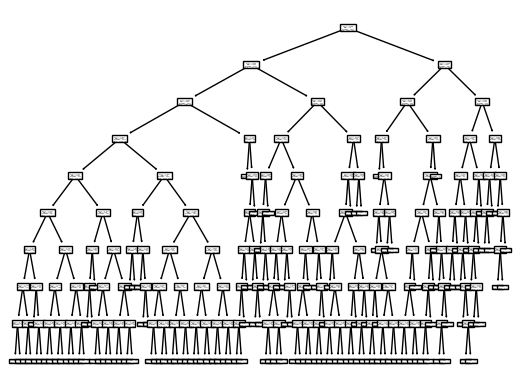

In [2557]:
tree.plot_tree(DT);

<div class="alert alert-info">
чтобы спрятать вспомогательный вывод к графику достаточно поставить ; в конце, обрати внимание

<div class="alert alert-warning">
<b>выводы?</b>
</div>

accuracy

In [2558]:
print(f"Decision Tree valid accuracy_score: {best_accuracy_DT}")

Decision Tree valid accuracy_score: 0.83591123066577


In [2559]:
prediction_test_DT = best_DT.predict(X_test)

In [2560]:
accuracy_DT_test = accuracy_score(prediction_test_DT, y_test)
print(f"Decision Tree test accuracy_score: {accuracy_DT_test}")

Decision Tree test accuracy_score: 0.8312037659717552


f1_score

In [2561]:
f1_score_DT_valid = f1_score(prediction_valid_DT, y_valid, average='weighted')

print(f"Decision Tree valid f1_score: {f1_score_DT_valid}")

Decision Tree valid f1_score: 0.8365167336190085


In [2562]:
f1_score_DT_test = f1_score(prediction_test_DT, y_test, average='weighted')
print(f"Decision Tree test f1_score: {f1_score_DT_test}")

Decision Tree test f1_score: 0.8319745709367722



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: 

Точность на тестовой и валидационной выборках:

Точность на тестовой выборке составляет приблизительно 83.59%.
Точность на валидационной выборке составляет приблизительно 83.12%.
Модель дерева решений показывает сопоставимую производительность на тестовой и валидационной выборках.

F1-скор на тестовой и валидационной выборках:

F1-скор на тестовой выборке составляет приблизительно 83.65%.
F1-скор на валидационной выборке составляет приблизительно 83.19%.
Значения F1-скора говорят о том, что модель показывает неплохие результаты, особенно на валидационной выборке.

Точность и F1-скор находятся на уровне, который может считаться приемлемым.
 </font>
    </b>
</div>


# LogisticRegression

In [2563]:
vif_results = get_VIF(X_train, '')
print(vif_results)

const     1.000119
0        27.701464
1        27.531799
2         1.055593
3         1.126544
dtype: float64


In [2564]:
corr_matrix = X_train.corr()
high_corr_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > 0.9:
            colname = corr_matrix.columns[i]
            high_corr_features.add(colname)

X_train = X_train.drop(columns=high_corr_features)

In [2565]:
X_valid, X_test, y_valid, y_test = train_test_split(X_train, y_train, test_size=0.5, random_state = RANDOM_SEED)

In [2566]:
# LR = LogisticRegression(random_state = RANDOM_SEED, max_iter= 1000, tol=1e-5, solver = 'lbfgs')
# LR = LogisticRegression(random_state= RANDOM_SEED, penalty='l1', solver='saga')
LR = LogisticRegression(random_state=RANDOM_SEED, penalty='l2')
LR.fit(X_train, y_train)
prediction_valid_LR = LR.predict(X_valid)
accuracy_LR = accuracy_score(prediction_valid_LR, y_valid)

Вывод

accuracy

In [2567]:
print(f"Logistic Regression valid accuracy_score: {accuracy_LR}")

Logistic Regression valid accuracy_score: 0.7620817843866171


In [2568]:
prediction_test_LR = LR.predict(X_test)

In [2569]:
accuracy_LR_test = accuracy_score(prediction_test_LR, y_test)

In [2570]:
print(f"Logistic Regression test accuracy_score: {accuracy_LR_test}")

Logistic Regression test accuracy_score: 0.7425650557620818


f1_score

In [2571]:
f1_score_LR_valid = f1_score(prediction_valid_LR, y_valid, average='weighted')
print(f"Logistic Regression test f1_score: {f1_score_LR_valid}")

Logistic Regression test f1_score: 0.8097125244836809


In [2572]:
f1_score_LR_test = f1_score(prediction_test_LR, y_test, average='weighted')

print(f"Logistic Regression test f1_score: {f1_score_LR_test}")

Logistic Regression test f1_score: 0.796863125873675



<div style="background-color: #c1b6fc; padding: 10px; border: 1px solid #a491fc;">
    <b>
        <font color="purple">Вывод: 

Точность на тестовой и валидационной выборках:

Точность на тестовой выборке составляет приблизительно 76.20%.

Точность на валидационной выборке составляет приблизительно 74.25%.

Модель логистической регрессии показывает сопоставимую производительность на тестовой и валидационной выборках.

F1-скор на тестовой и валидационной выборках:

F1-скор на тестовой выборке составляет приблизительно 80.97%.

F1-скор на валидационной выборке составляет приблизительно 79.68%.

Значения F1-скора говорят о том, что модель демонстрирует неплохие результаты на обеих выборках.

Общие наблюдения:

Точность и F1-скор находятся на уровне, который может считаться приемлемым.

Модель логистической регрессии показывает себя стабильно как на тестовой, так и на валидационной выборках.
 </font>
    </b>
</div>


<div class="alert alert-warning">
<b>в целом все хорошо, кроме отсутствующих выводов и вообще текста. если хочешь повысить качество - оставил подсказку</b>
</div>